In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

import os

# Configs

In [0]:
data_PATH = os.path.join("/content/celeba/")
log_PATH = os.path.join("/gdrive/My Drive/notebooks/logs/began64")
modelName = "BEGAN-celeba_64x64"

batch_size =16
workers = 2

h_dim = 128

gf_dim = 64
df_dim = 64

in_h = 64
in_w =64
c_dim = 3

start_step = 0
lr_update_step = 100*1000
max_step = 200 * 1000

learning_rate_1 = 0.00008
learning_rate_2 = learning_rate_1 *0.5

beta1=0.5
beta2=0.9
betas = (beta1,beta2)

gamma = 0.5
lambda_k = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


# DataLoad

In [0]:
transform = transforms.Compose(
    [
     
    transforms.CenterCrop(160),
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)), 
     ]
)
def transform_inverse (y):
  t= None
  if y.size()[0]==1:#1-dim
    t=torchvision.transforms.Normalize((-1,),(2,))
  else :#3-dim
    t=torchvision.transforms.Normalize((-1,-1,-1),(2,2,2))
  return t(y)

In [0]:
thumbnails_dataset=torchvision.datasets.ImageFolder(root = data_PATH,transform=transform)
train_loader = torch.utils.data.DataLoader(thumbnails_dataset,batch_size=batch_size,
                                           shuffle =True, num_workers=workers)
train_iter=iter(train_loader)
print(thumbnails_dataset)

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: /content/celeba/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(160, 160))
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


torch.Size([16, 3, 64, 64])


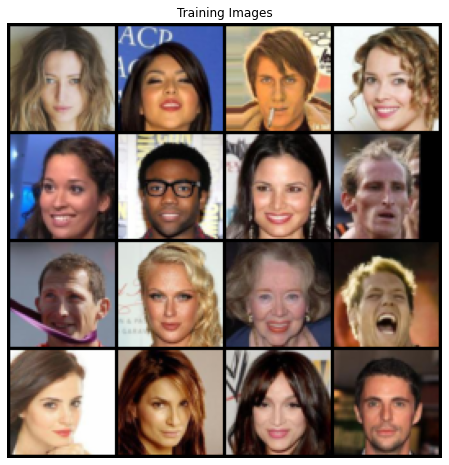

In [0]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device),nrow=4,padding=2, normalize=True).cpu(),(1,2,0)))
print(real_batch[0].size())

# Model 

In [0]:
import torch.nn as nn

def conv_elu(in_dim, out_dim, kernel_size,stride,padding=0, bias=True):
    return nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=kernel_size, stride=stride,padding=padding,bias=bias),
        nn.ELU(inplace=True)
    )

def encoder_net(input_height, input_dim, df_dim,h_dim):
  repeat_times = int(np.log2(input_height)) - 2 
  encoder_list = []

  encoder_list.append( conv_elu(input_dim,df_dim,3,1,1) )
  out_dim = df_dim
  for idx in range(repeat_times):
    prev_dim = out_dim
    out_dim = df_dim * (idx + 1)
    encoder_list.append(conv_elu(prev_dim,out_dim,3,1,1))
    encoder_list.append(conv_elu(out_dim,out_dim,3,1,1))
    
    if idx < repeat_times - 1:
      encoder_list.append(conv_elu(out_dim,out_dim,3,2,1))
  encoder_list.append(nn.Sequential(
    nn.Flatten(1),
    nn.Linear(8*8*out_dim,h_dim)
  ))
  return nn.Sequential(*encoder_list)

def decoder_cnn(input_height, output_dim, gf_dim):
  repeat_times = int(np.log2(input_height)) - 2 
  decoder_list = []
  for idx in range(repeat_times):
    decoder_list.append(conv_elu(gf_dim,gf_dim,3,1,1))
    decoder_list.append(conv_elu(gf_dim,gf_dim,3,1,1))
    if idx < repeat_times - 1:
      decoder_list.append(nn.UpsamplingNearest2d(scale_factor=2))
  decoder_list.append(nn.Conv2d(gf_dim, output_dim, 3,1,1))
  return nn.Sequential(*decoder_list)


In [0]:
import torch.nn as nn

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.encoder = encoder_net(in_h,c_dim,df_dim,h_dim)
    self.decoder_linear = nn.Linear(h_dim,8*8*df_dim)
    self.decoder_cnn = decoder_cnn(in_h,c_dim,df_dim)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder_linear(x).view(-1,df_dim,8,8)
    x = self.decoder_cnn(x)
    return x

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.decoder_linear = nn.Linear(h_dim,8*8*gf_dim)
    self.decoder_cnn = decoder_cnn(in_h,c_dim,gf_dim)

  def forward(self,x):
    x = self.decoder_linear(x).view(-1,gf_dim,8,8)
    x = self.decoder_cnn(x)
    return x

# Train Cofigs

In [0]:
import torch.optim as optim

D = Discriminator().to(device)
G = Generator().to(device)

G_optimizer = optim.Adam(G.parameters(),lr = learning_rate, betas = betas)
D_optimizer = optim.Adam(D.parameters(),lr = learning_rate, betas = betas)

k_t = 0.0

L1_criterion = nn.L1Loss()

fixed_noise = torch.rand(64,h_dim).to(device) * 2 - 1

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (5): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0, inplace=True)
    )
    (6): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [0]:
def denorm_clipping_img(image):
  return torch.clamp( ((image + 1)/2), 0, 1)

def norm_img(image):
  return image/0.5 - 1.

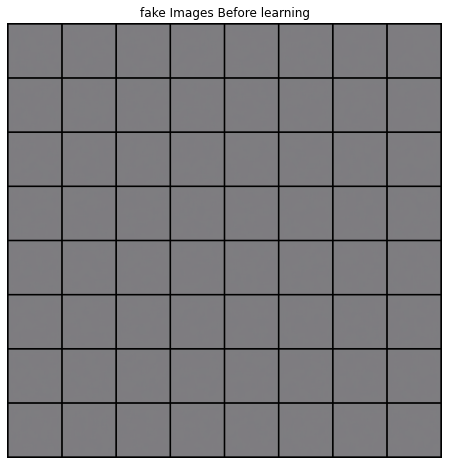

In [0]:
with torch.no_grad():
  fake_batch=G(fixed_noise)
  fake_batch=denorm_clipping_img(fake_batch)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images Before learning')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(64,c_dim,in_h,in_w),padding=2, normalize=False).cpu(),(1,2,0)))

In [0]:
import pickle

img_list = []

G_losses = []
D_losses = []

real_losses = []
fake_losses = []

convergence_measure_list = []

transform_PIL=transforms.ToPILImage()

def log_list_save(l,file_name):
  with open(os.path.join(log_PATH ,file_name+".logs"), "wb") as fp:
    pickle.dump(l, fp)

def log_list_load(file_name):
  with open(os.path.join(log_PATH ,file_name+".logs"), "rb") as fp:
    return pickle.load(fp)

log_step = 100
save_step = 1000

# Train

In [0]:
for step in range(start_step,lr_update_step):
  try:
    real_data,_ = train_iter.next()
  except StopIteration:
    train_iter = iter(train_loader)
  
  batch_size=real_data.shape[0] 
  real_data = norm_img(real_data.to(device))
  z = torch.rand(batch_size,h_dim).to(device) * 2 - 1 # [-1,1] uniform
  fake_data = G(z)
  D.zero_grad()

  d_loss_real =L1_criterion(D(real_data),real_data)
  d_loss_fake =L1_criterion(D(fake_data.detach()),fake_data.detach())
  d_loss = d_loss_real - k_t * d_loss_fake
  d_loss.backward()
  D_optimizer.step()

  G.zero_grad()
  g_loss = L1_criterion(D(fake_data),fake_data)
  g_loss.backward()
  G_optimizer.step() 
  
  balance = (gamma * d_loss_real - d_loss_fake).data
  k_t = torch.clamp(k_t+lambda_k*balance, 0, 1).item()


  convergence_measure = (d_loss_real + torch.abs(balance)).item()

  if step % log_step ==0:
    print("Steps [{}/{}], convergence: {:.4f}, D_loss: {:.4f}, G_loss: {:.4f}, real_loss: {:.4f}, fake_loss: {:.4f}, k_t: {:.2f}"
    .format(step,max_step, convergence_measure,d_loss.item(), g_loss.item(),  d_loss_real.item(), d_loss_fake.item(), k_t))

    D_losses.append(d_loss.item())
    G_losses.append(g_loss.item())
    real_losses.append(d_loss_real.item())
    fake_losses.append(d_loss_fake.item())
    convergence_measure_list.append(convergence_measure)

    log_list_save(D_losses,os.path.join(log_PATH,"D_losses"))
    log_list_save(G_losses,os.path.join(log_PATH,"G_losses"))
    log_list_save(real_losses,os.path.join(log_PATH,"real_losses"))
    log_list_save(fake_losses,os.path.join(log_PATH,"d_loss_fake"))
    log_list_save(convergence_measure_list,os.path.join(log_PATH,"convergence_measure_list"))


  if step % save_step == save_step - 1:
    torch.save(G.state_dict(),os.path.join(log_PATH,"G_"+modelName+".pth"))
    torch.save(D.state_dict(),os.path.join(log_PATH,"D_"+modelName+".pth"))
    with torch.no_grad():
      fake = G(fixed_noise).detach().cpu()
      fake = denorm_clipping_img(fake) # instead of tanh activation
    img_list.append(vutils.make_grid(torch.reshape(fake,(64,c_dim,in_h,in_w)), padding=2, normalize=False))
    transform_PIL(img_list[-1]).save(os.path.join(log_PATH,str(step)+modelName+"_Last.png"))

Steps [0/200000], convergence: 0.7026, D_loss: 0.4929, G_loss: 0.0389, real_loss: 0.4929, fake_loss: 0.0368, k_t: 0.00
Steps [100/200000], convergence: 0.3133, D_loss: 0.2792, G_loss: 0.1414, real_loss: 0.2794, fake_loss: 0.1058, k_t: 0.00
Steps [200/200000], convergence: 0.2871, D_loss: 0.2608, G_loss: 0.0971, real_loss: 0.2613, fake_loss: 0.1048, k_t: 0.00
Steps [300/200000], convergence: 0.2411, D_loss: 0.2182, G_loss: 0.0793, real_loss: 0.2187, fake_loss: 0.0869, k_t: 0.01
Steps [400/200000], convergence: 0.2512, D_loss: 0.2328, G_loss: 0.0876, real_loss: 0.2335, fake_loss: 0.0991, k_t: 0.01
Steps [500/200000], convergence: 0.2560, D_loss: 0.2183, G_loss: 0.1121, real_loss: 0.2189, fake_loss: 0.0724, k_t: 0.01
Steps [600/200000], convergence: 0.2126, D_loss: 0.1971, G_loss: 0.1466, real_loss: 0.1979, fake_loss: 0.0843, k_t: 0.01
Steps [700/200000], convergence: 0.2464, D_loss: 0.2165, G_loss: 0.1105, real_loss: 0.2176, fake_loss: 0.0800, k_t: 0.01
Steps [800/200000], convergence: 0

In [253]:
G_optimizer = optim.Adam(G.parameters(),lr = 0.00004, betas = betas)
D_optimizer = optim.Adam(D.parameters(),lr = 0.00004, betas = betas)
for step in range(lr_update_step,max_step):
  try:
    real_data,_ = train_iter.next()
  except StopIteration:
    train_iter = iter(train_loader)
  
  batch_size=real_data.shape[0] 
  real_data = norm_img(real_data.to(device))
  z = torch.rand(batch_size,h_dim).to(device) * 2 - 1 # [-1,1] uniform
  fake_data = G(z)
  D.zero_grad()

  d_loss_real =L1_criterion(D(real_data),real_data)
  d_loss_fake =L1_criterion(D(fake_data.detach()),fake_data.detach())
  d_loss = d_loss_real - k_t * d_loss_fake
  d_loss.backward()
  D_optimizer.step()

  G.zero_grad()
  g_loss = L1_criterion(D(fake_data),fake_data)
  g_loss.backward()
  G_optimizer.step() 
  
  balance = (gamma * d_loss_real - d_loss_fake).data
  k_t = torch.clamp(k_t+lambda_k*balance, 0, 1).item()


  convergence_measure = (d_loss_real + torch.abs(balance)).item()

  if step % log_step ==0:
    print("Steps [{}/{}], convergence: {:.4f}, D_loss: {:.4f}, G_loss: {:.4f}, real_loss: {:.4f}, fake_loss: {:.4f}, k_t: {:.2f}"
    .format(step,max_step, convergence_measure,d_loss.item(), g_loss.item(),  d_loss_real.item(), d_loss_fake.item(), k_t))

    D_losses.append(d_loss.item())
    G_losses.append(g_loss.item())
    real_losses.append(d_loss_real.item())
    fake_losses.append(d_loss_fake.item())
    convergence_measure_list.append(convergence_measure)

    log_list_save(D_losses,os.path.join(log_PATH,"D_losses"))
    log_list_save(G_losses,os.path.join(log_PATH,"G_losses"))
    log_list_save(real_losses,os.path.join(log_PATH,"real_losses"))
    log_list_save(fake_losses,os.path.join(log_PATH,"d_loss_fake"))
    log_list_save(convergence_measure_list,os.path.join(log_PATH,"convergence_measure_list"))


  if step % save_step == save_step - 1:
    torch.save(G.state_dict(),os.path.join(log_PATH,"G_"+modelName+".pth"))
    torch.save(D.state_dict(),os.path.join(log_PATH,"D_"+modelName+".pth"))
    with torch.no_grad():
      fake = G(fixed_noise).detach().cpu()
      fake = denorm_clipping_img(fake) # instead of tanh activation
    img_list.append(vutils.make_grid(torch.reshape(fake,(64,c_dim,in_h,in_w)), padding=2, normalize=False))
    transform_PIL(img_list[-1]).save(os.path.join(log_PATH,str(step)+modelName+"_Last.png"))

Steps [100000/200000], convergence: 0.0858, D_loss: 0.0821, G_loss: 0.0422, real_loss: 0.0835, fake_loss: 0.0441, k_t: 0.03
Steps [100100/200000], convergence: 0.0833, D_loss: 0.0814, G_loss: 0.0424, real_loss: 0.0827, fake_loss: 0.0407, k_t: 0.03
Steps [100200/200000], convergence: 0.0953, D_loss: 0.0878, G_loss: 0.0380, real_loss: 0.0890, fake_loss: 0.0382, k_t: 0.03
Steps [100300/200000], convergence: 0.0670, D_loss: 0.0658, G_loss: 0.0348, real_loss: 0.0669, fake_loss: 0.0334, k_t: 0.03
Steps [100400/200000], convergence: 0.0780, D_loss: 0.0750, G_loss: 0.0373, real_loss: 0.0762, fake_loss: 0.0363, k_t: 0.03
Steps [100500/200000], convergence: 0.0879, D_loss: 0.0819, G_loss: 0.0384, real_loss: 0.0831, fake_loss: 0.0367, k_t: 0.03
Steps [100600/200000], convergence: 0.0822, D_loss: 0.0751, G_loss: 0.0436, real_loss: 0.0765, fake_loss: 0.0439, k_t: 0.03
Steps [100700/200000], convergence: 0.0858, D_loss: 0.0769, G_loss: 0.0304, real_loss: 0.0779, fake_loss: 0.0311, k_t: 0.03
Steps [1

# Test

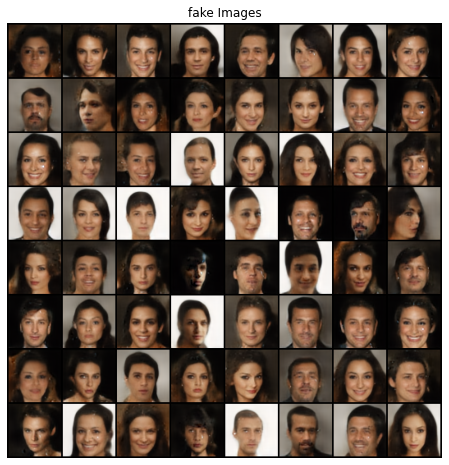

In [254]:
with torch.no_grad():
  fake_batch=G(fixed_noise)
  fake_batch=denorm_clipping_img(fake_batch)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(64,c_dim,in_h,in_w),padding=2, normalize=False).cpu(),(1,2,0)))

In [0]:
'''
For interpolation on the latent space
code from : https://github.com/soumith/dcgan.torch/issues/14
'''
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

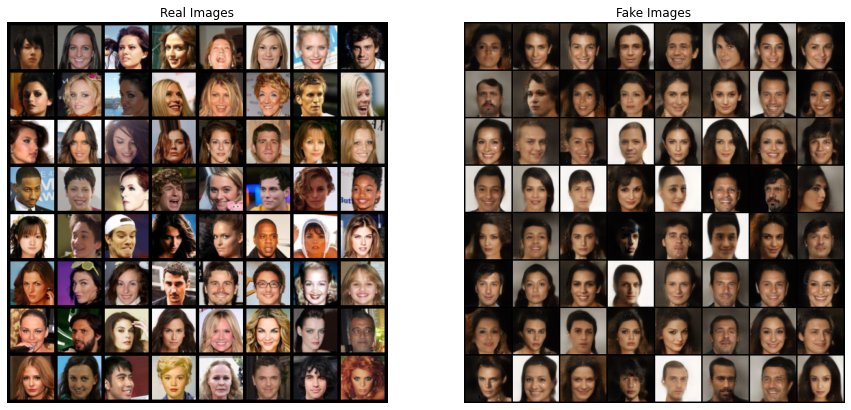

In [262]:
for i in range(4):
  if i ==0:
    real_batch, _ = next(iter(train_loader))
  else:
    data, _ = next(iter(train_loader))
    real_batch=torch.cat([real_batch, data], dim=0)

# Plot the real images
fig=plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

fig.savefig(os.path.join(log_PATH,"Compare_with_real"))

In [0]:
from PIL import Image
transform_PIL=transforms.ToPILImage()

p_img_list = [transform_PIL(p_image) for p_image in img_list]
p_img_list[0].save(os.path.join(log_PATH,modelName+'.gif'), save_all=True,append_images=p_img_list[1:], optimize=False, duration=0.5, loop=0)
p_img_list[-1].save(os.path.join(log_PATH,modelName+"_last_result.png"))

# Logging

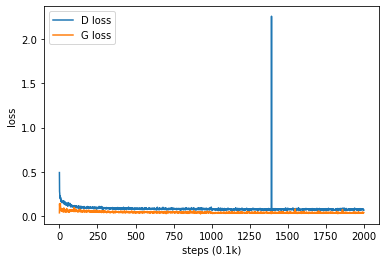

In [278]:
x_len = int(max_step/log_step)
X = range(x_len)

plt.plot(X,D_losses,label="D loss")
plt.plot(X,G_losses,label="G loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,x_len+1,250)) 
plt.ylabel("loss")
plt.xlabel("steps (0.1k)")
#plt.show()
plt.savefig(os.path.join(modelName+"_loss_figure_D,G.png"))

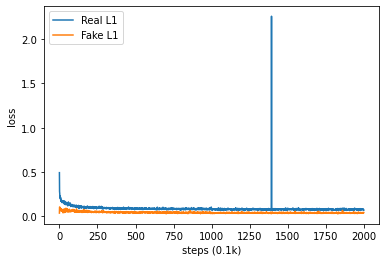

In [279]:
plt.plot(X,real_losses,label="Real L1")
plt.plot(X,fake_losses,label="Fake L1")
plt.legend(loc=2)
plt.xticks(np.arange(0,x_len+1,250)) 
plt.ylabel("loss")
plt.xlabel("steps (0.1k)")
#plt.show()
plt.savefig(os.path.join(modelName+"_loss_figure_Real,Fake.png"))

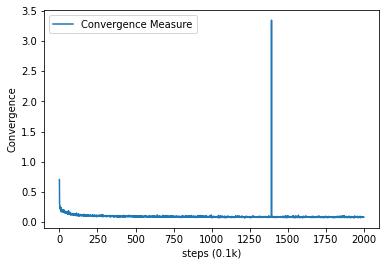

In [283]:
plt.plot(X,convergence_measure_list,label="Convergence Measure")
plt.legend(loc=2)
plt.xticks(np.arange(0,x_len+1,250)) 
plt.ylabel("Convergence")
plt.xlabel("steps (0.1k)")
#plt.show()
plt.savefig(os.path.join(modelName+"_loss_figure_convergence.png"))

In [284]:
torch.save(G.state_dict(),os.path.join(log_PATH,"G_"+modelName+".pth"))
G.load_state_dict(torch.load(os.path.join(log_PATH,("G_"+modelName+".pth"))))

<All keys matched successfully>

In [285]:
torch.save(D.state_dict(),os.path.join(log_PATH,"D_"+modelName+".pth"))
D.load_state_dict(torch.load(os.path.join(log_PATH,("D_"+modelName+".pth"))))

<All keys matched successfully>